In [45]:
import json
import requests
import json
import matplotlib
import re
import pydot
from graphviz import Digraph
from graphviz import Source
from inference_utils import Utils
import networkx as nx
from networkx.readwrite import json_graph

In [117]:
from enum import Enum

class EdgeStatus(Enum):
    wiktdata_error = 1
    double_edge_error = 2
    single_zero_success = 3
    no_edge_success = 4
    neutral = 5
    edge_not_found = 6
    node_not_found = 7

def append_wikidata(graph, triplet, rule):
    curr_edges = [
        (n1, n2, d['color']) for n1, n2, d in graph.edges(data=True)]

    if triplet['arg1'] is "novalue" or triplet['arg2'] is "novalue" or triplet['arg3'] is "novalue":
        return EdgeStatus.wiktdata_error
    
    a = nx.get_node_attributes(graph,'str_name')
    
    for n in a:
        if a[n] == triplet['arg2']:
            nulledgecount = 0
            edgetoit = False
            for e in curr_edges:
                #megy e bele el
                if e[1] == n:
                    edgetoit = True
                    
                if e[0] == n:
                    #ketts el vizsgalata
                    for c in curr_edges:
                        if c[0] == e[1] and c[1] == n:
                            return EdgeStatus.double_edge_error
                        
                if rule == 0:
                    if e[2] == 0:
                        nulledgecount+=1
                        if triplet['arg3'] not in a:
                            graph.add_node(triplet['arg3']+'_', str_name=triplet['arg3'], expanded=True)
                            graph.add_edge(triplet['arg3']+'_', e[1], color=0)
                            
                if rule == 2:
                    if e[2] == 2:
                        nulledgecount+=1
                        if triplet['arg3'] not in a:
                            graph.add_node(triplet['arg3']+'_', str_name=triplet['arg3'], expanded=True)
                            graph.add_edge(triplet['arg1']+'_', e[1], color=0)

            if nulledgecount == 0:
                return EdgeStatus.edge_not_found
            if nulledgecount == 1:
                return EdgeStatus.single_zero_success
            if edgetoit == False:
                return EdgeStatus.no_edge_success
            
            return EdgeStatus.neutral

    return EdgeStatus.node_not_found

In [124]:
triplets = {}
graphs = {}
statuses = {}
count = 0
with open("togetherfiltered.json", "r+") as f:
    for l in f:
        line = eval(l)
        predicate = line['arg2']
        data = {'word':   predicate}
        data_json = json.dumps(data)
        payload = {'json_payload': data_json}
        headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

        r = requests.post("http://127.0.0.1:5000/wikidata", data=data_json, headers=headers)
        
        word_graph = r.json()['word']
        g_word_graph = json_graph.adjacency.adjacency_graph(word_graph)
        
        status = append_wikidata(g_word_graph, line, 0)
        
        triplets[count] = (line['arg1'], line['arg2'], line['arg3'])
        graphs[count] = g_word_graph
        statuses[count] = status
        count+=1

In [129]:
alg_success = [k for k in statuses.values() if k in [EdgeStatus(3), EdgeStatus(4), EdgeStatus(5)]]
len(alg_success)

1726

In [126]:
utils = Utils()
g_dot = utils.to_dot(graphs[23])
print(g_dot)

digraph finite_state_machine {
	dpi=100;
	association_football_player_ [shape = circle, label = "association_football_player"];
	job_139629397255440 [shape = circle, label = "job"];
	occupation_139629397254224 [shape = circle, label = "occupation"];
	profession_139629406289552 [shape = circle, label = "profession"];
	association_football_player_ -> job_139629397255440 [ label = "0" ];
	association_football_player_ -> profession_139629406289552 [ label = "0" ];
	occupation_139629397254224 -> job_139629397255440 [ label = "0" ];
	occupation_139629397254224 -> profession_139629406289552 [ label = "0" ];
}


In [127]:
v_g = Source(g_dot)

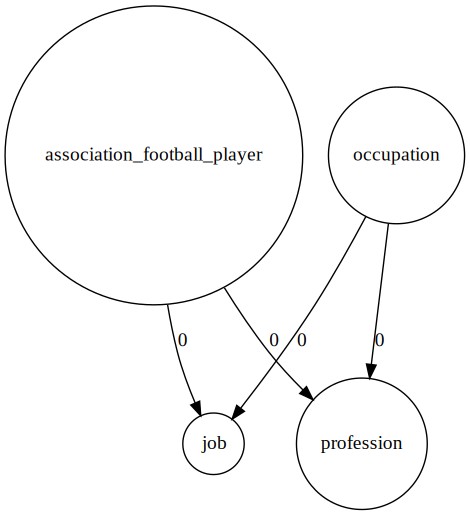

In [128]:
v_g